# PS1: Building Probabilistic Cellular Automata
In this activity, we will finish a program that computes two-color one-dimensional cellular automata. In particular, we'll simulate [Rule 30](https://en.wikipedia.org/wiki/Rule_30), a one-dimensional cellular automaton rule introduced by Stephen Wolfram in 1983. It is particularly interesting because it produces complex, seemingly random patterns from simple, well-defined rules.

We'll look at two formulations of this model. After we set up the computational environment, we'll simulate a system described by a deterministic one-dimensional cellular automaton in Task 1, and then in Task 2 we'll explore a probabilistic version of the same model.

This is a fascinating area of study that combines elements of physics, computer science, and mathematics. 

> __Applications?__
 >
> Cellular automata have been used to model a wide range of phenomena, from the behavior of gases to the spread of diseases. 
 > * Rule 30 has found practical applications in cryptography and random number generation. Mathematica software has used Rule 30 as part of its default random number generator for over two decades. See: Wolfram, 2002, "A New Kind of Science"
 > * Additionally, cellular automata models have been successfully applied to study pattern formation in biological systems, including shell pigmentation patterns in mollusks and the development of cellular tissues. See: Ermentrout GB, Edelstein-Keshet L. Cellular automata approaches to biological modeling. J Theor Biol. 1993 Jan 7;160(1):97-133. doi: 10.1006/jtbi.1993.1007. PMID: 8474249.
 >
> Today, we will explore the world of cellular automata and their applications.

Very cool stuff, with many practical and theoretical implications. Let's get started!
___

## Setup, Data, and Prerequisites
First, we set up the computational environment by including the `Include.jl` file and loading any needed resources.

> __Include:__ The [include command](https://docs.julialang.org/en/v1/base/base/#include) evaluates the contents of the input source file, `Include.jl`, in the notebook's global scope. The `Include.jl` file sets paths, loads required external packages, etc. For additional information on the Julia functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/). 

Set up the environment by running the following code cell:

In [27]:
include(joinpath(@__DIR__, "Include-student.jl"));

In addition to standard Julia libraries, we'll also use [the `VLDataScienceMachineLearningPackage.jl` package](https://github.com/varnerlab/VLDataScienceMachineLearningPackage.jl). Check out [the documentation](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/) for more information on the functions, types, and data used in this material.

### Constants
Before we get to the simulations, we need to set some constants. See the descriptions in the comments for each constant for more details, permissible values, units, etc.

In [28]:
# what rule do we want to see?
colors = 2; # black and white
radius = 3; # radius of the rule - we look at three states
rule_index = 30; # what rule do we want to see?
number_of_steps = 240; # number of time steps > 0
number_of_states = 2^8; # number of states in the system > 3

___

## Task 1: Deterministic Cellular Automata
In this task, we will implement a deterministic one-dimensional cellular automaton [using Rule 30](https://en.wikipedia.org/wiki/Rule_30). We'll start with a simple initial condition and evolve the system over a number of time steps. Let's build a model of the one-dimensional grid world, which we model [as an instance of the `MyOneDimensionalElementaryWolframRuleModel` type](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/types/#VLDataScienceMachineLearningPackage.MyOneDimensionalElementaryWolframRuleModel). 

We construct [a `MyOneDimensionalElementaryWolframRuleModel` instance](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/types/#VLDataScienceMachineLearningPackage.MyOneDimensionalElementaryWolframRuleModel) using [a `build(...)` method](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/factory/), which takes the index of the rule we want to simulate, the number of possible states for each grid element (colors), and the width of the neighborhood that a cell looks at to make a decision.

Let's store our world model in the `rulemodel::MyOneDimensionalElementaryWolframRuleModel` variable.

In [29]:
rulemodel = let
    
    build(MyOneDimensionalElementaryWolframRuleModel, (
        index=rule_index, 
        colors=colors, 
        radius=radius
    ));
 
end


MyOneDimensionalElementaryWolframRuleModel(30, 3, 2, Dict(0 => 0, 4 => 1, 5 => 0, 6 => 0, 2 => 1, 7 => 0, 3 => 1, 1 => 1))

What's in the `rulemodel::MyOneDimensionalElementaryWolframRuleModel` model? We can see the fields of the model type using [the `fieldnames(...)` function](https://docs.julialang.org/en/v1/base/base/#Base.fieldnames). Let's take a look:

In [30]:
typeof(rulemodel) |> fieldnames # we can see the fields of the model type using the fieldnames function

(:index, :radius, :number_of_colors, :rule)

Most of the stored data is what you would expect, but there is one interesting field: `rule`. This field contains the specific rule being applied in the simulation, which is crucial for understanding the dynamics of the system.

In [31]:
rulemodel.rule

Dict{Int64, Int64} with 8 entries:
  0 => 0
  4 => 1
  5 => 0
  6 => 0
  2 => 1
  7 => 0
  3 => 1
  1 => 1

<div>
    <center>
      <img
        src="figs/Rule-30-NeedToRedraw-CutFromWeb.png"
        alt="Rule 30 Example"
      />
    </center>
  </div>

The top row shows the _current state_ of the system, while the bottom row shows the _next state_ after applying the rule. This visualization helps in understanding how the rule transforms the system over time.

For example, consider the farthest right-hand state. If at $t$ the neighbors of state $i$ are all in state `0` (white), then according to Rule 30, the next state of $i$ will be `0` (white). However, if the right-most neighbor is in state `1` (black), but all others are `0` (white), then the next state of cell $i$ will be `1` (black).

Ok, so I get that, but how do we compute the `rule` field in the model? This is going to blow your mind!
* The keys of the rule dictionary are the base $b$ representations of the neighborhood states, e.g., $(000)_{2} = 0$, $(001)_{2} = 1$, $(010)_{2} = 2$, $(011)_{2} = 3$, $(100)_{2} = 4$, $(101)_{2} = 5$, $(110)_{2} = 6$, $(111)_{2} = 7$. The values are the _next states_ of cell $i$ after applying the rule. 
* Where does rule 30 come from? Look at the next states. The next states written in binary $(00011110)_{2} = 30$. Super cool. 
* The state-next state diagram for any configuration looks like a simple (upside-down) ternary tree

Thus, in an elementary Wolfram-type cellular automata model, we exhaustively compute every possible configuration of a cell's neighborhood and then map that to the next state.

If you play with the rule index, you'll see how the different configurations lead to different behaviors in the system.

### Standard Simulation Algorithm
Now that we have a model of our one-dimensional world and the rules that govern it, let's simulate the dynamics of the world forward in time. To do this, we call [the `simulate(...)` method](src/Wolfram.jl), either as a deterministic world or a stochastic world. 

Let's sketch out a basic deterministic simulation algorithm in pseudocode.

__Initialize__: Given the initial cell state vector $\mathbf{s}\in\mathbb{Z}^{n}_{0,1}$ where $n$ is the number of cells in the one-dimensional grid, the number of time steps $T$, and a rule $R:N(\mathbf{s})\to\mathbf{s}^{\prime}$, where $N(\mathbf{s})$ is the neighborhood of a cell in the state vector. We assume periodic boundary conditions for the neighborhood function.

Time proceeds in discrete steps, where we initialize the time index $t\gets{0}$.

For each $t=1,\ldots,T$ __do__:
1. Get the current state vector: $\mathbf{s}\gets\mathbf{s}_{t-1}$
1. Initialize temporary state vector: $\mathbf{s}^{\text{temp}} \gets \mathbf{0}$
1. For each $i=1,\ldots,n$ __do__:
    * Compute the neighborhood $\hat{\mathbf{s}}\gets{N}(i,\mathbf{s})$ of the cell at location $i$.
    * Apply rule $R$ to the neighborhood of cell $i$, to get the next state: $s_{i}^{\prime}\gets R(\hat{\mathbf{s}})$
    * Store the updated state in the temporary vector: $\mathbf{s}^{\text{temp}}[i]\gets s_{i}^{\prime}$
1. Update state for next iteration: $\mathbf{s}_{t} \gets \mathbf{s}^{\text{temp}}$

At the end of the time step $t$, we have the updated state vector $\mathbf{s}_{t}$. 
 > __Why a temp state variable?__ The temporary buffer ensures that all cells read from the same consistent state at time $t-1$, which is required for the synchronous update semantics of cellular automata. 

We can store these vectors in a buffer and can then replay the simulation from any time step. Alternatively, we could store $T\times{n}$ simulation _frames_ where at each time step we are updating a row in the two-dimensional array. This is probably not the most memory-efficient choice!

Let's run the deterministic simulation and store the results in the `base_frames::Dict{Int64, Array{Int64, 2}}` variable. To get the deterministic simulation, we call [the `simulate(...)` method](src/Wolfram.jl) with the `algorithm = WolframDeterministicSimulation()` argument.

In [32]:
base_frames = let

    # Initialize -
    initial = zeros(Int64, number_of_states); # Initial condition of the system
    initial[round(number_of_states/2) |> Int] = 1; # Middle state is 1, all other states are 0
    base_frames = nothing; # Initialize the base frames variable
    
    base_frames = simulate(rulemodel, initial, steps=number_of_steps, 
        algorithm = WolframDeterministicSimulation());

    base_frames;
end


Dict{Int64, Matrix{Int64}} with 240 entries:
  56  => [0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0]
  35  => [0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0]
  60  => [0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0]
  220 => [0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0]
  67  => [0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0]
  215 => [0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0]
  73  => [0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0]
  115 => [0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0]
  112 => [0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0]
  185 => [0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0]
  86  => [0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0]
  168 => [0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0]
  207 => [0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0]
  183 => [0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0]
  224 => [0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0]
  177 => [0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0]
  12  => [0 0 … 0 0; 0 0 … 

We can visualize the simulation results using a variety of techniques, such as plotting the state of the system at different time steps or creating animations to show the evolution of the system over time.

Here, let's visualize the individual simulation _frames_ stored in the `base_frames::Dict{Int64, Matrix{Int64}}` dictionary at some time index you select using [the `Images.jl` package](https://github.com/JuliaImages/Images.jl) to display the frames as grayscale images.

> __Correct:__ If your simulation is working correctly, you should see the characteristic triangular pattern of Rule 30 emerge from the initial condition over time. Run the solution code to visualize the results and confirm that the simulation behaves as expected.

So, what do you see?

[ Info: Saved animation to /Users/zhangjiawei/Documents/GitHub/PS1-CHEME-4800-5800-TEMPLATE-Fall-2025/tmp.gif


Plots.AnimatedGif("/Users/zhangjiawei/Documents/GitHub/PS1-CHEME-4800-5800-TEMPLATE-Fall-2025/tmp.gif")
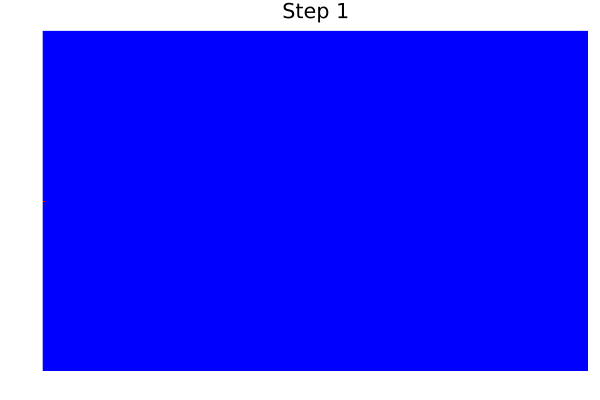

In [52]:
using Plots

@gif for t in 1:number_of_steps
    heatmap(
        base_frames[t]',
        c = cgrad([:blue, :green, :yellow, :red]),
        legend = false,
        axis = false,
        title = "Step $t"
    )
end every 1  # Every 1 frames
# gif will be saved in the current working directory

In [34]:
do_you_see_deterministic_rule_30_simulation_figure = true; # set to true if you see the figure above


### What do we see?
Each horizontal line in the visualization represents the state of all cells at a specific time step, with black pixels indicating active cells (state 1) and white pixels representing inactive cells (state 0).

* The deterministic Rule 30 simulation produces a triangular pattern that emerges from the single activated cell at the center. Starting from this simple initial condition, the system evolves to create complex, seemingly random structures that expand outward in both directions as time progresses down the vertical axis.

* The pattern exhibits asymmetry despite the symmetric initial condition and deterministic rules. The left side shows more regular, periodic structures, while the right side displays chaotic, unpredictable behavior that appears almost random. This duality makes Rule 30 particularly interesting because it demonstrates how simple, deterministic local rules can generate both order and apparent randomness within the same system.

Next, let's add some randomness to the simulation.
___

## Task 2: Probabilistic Cellular Automata
In this task, we will implement a probabilistic one-dimensional cellular automaton [using Rule 30](https://en.wikipedia.org/wiki/Rule_30). We'll introduce randomness into the evolution process and observe how it affects the resulting patterns.

> __Randomness:__ The rule will stay the same; however, we introduce a random element into the state transitions. First, suppose that a cell in the current state undergoes the transition to the next state probabilistically, i.e., not every cell can _move_ at each time step. Second, if a cell does update its state, there will be a cooldown period before it can move again.

Let's sketch out some pseudocode for the stochastic variant of the grid-world simulation.

### Stochastic Simulation Algorithm

__Initialize__: Given the initial cell state vector $\mathbf{s}\in\mathbb{Z}^{n}_{0,1}$ where $n$ is the number of cells in the one-dimensional grid, the number of time steps $T$, a rule $R:N(\mathbf{s})\to\mathbf{s}^{\prime}$, where $N(\mathbf{s})$ is the neighborhood of a cell in the state vector, a parameter $p\in[0,1]$ representing the probability of a cell updating its state, and a cooldown period $c\in\mathbb{Z}^{+}$. Initialize a cooldown vector $\mathbf{c} \in \mathbb{N}_0^n$ with all zeros.

Time proceeds in discrete steps, where we initialize the time index $t\gets{0}$.

For each $t=1,\ldots,T$ __do__:

1. Update cooldown periods for all cells in the grid:
   * For each cell $j=1,\ldots,n$ __do__:
       - If the cooldown period for cell $j$ is greater than $0$, decrement it by $1$: $\mathbf{c}[j] \gets \max(0, \mathbf{c}[j] - 1)$

1. Initialize empty movement queue: $\texttt{Q} \gets \emptyset$

1. For each cell $i = 1,\ldots,n$ with $\mathbf{c}[i] = 0$ __do__:
   * With probability $p$, add the cell $i$ to the movement queue $\texttt{Q}\gets\texttt{Q} \cup \{i\}$.

1. Get the current state vector: $\mathbf{s}\gets\mathbf{s}_{t-1}$
1. Initialize temporary state vector: $\mathbf{s}^{\text{temp}} \gets \mathbf{s}$
1. While $\texttt{Q}$ is not empty __do__:
    * Dequeue a cell $i\gets\texttt{Q}.\texttt{dequeue}()$ from the movement queue.
    * Compute the neighborhood $\hat{\mathbf{s}}\gets{N}(i,\mathbf{s})$ of the cell at location $i$.
    * Apply rule $R$ to compute the next state: $s_{i}^{\prime}\gets R(\hat{\mathbf{s}})$ for cell $i$
    * Store the updated state in the temporary vector: $\mathbf{s}^{\text{temp}}[i]\gets s_{i}^{\prime}$
    * Set the cooldown period for cell $i$: $\mathbf{c}[i] \gets c$
1. Update state for next iteration: $\mathbf{s}_{t} \gets \mathbf{s}^{\text{temp}}$

The key differences from the deterministic case are the probabilistic queue selection and the cooldown mechanism that prevents recently updated cells from participating in immediate subsequent updates. 

Just like the deterministic case, we store the $T\times{n}$ simulation _frames_, where at each time step we are updating a row in the two-dimensional array.

Let's run the stochastic simulation and store the results in the `stochastic_frames::Dict{Int64, Array{Int64, 2}}` variable.
To get the stochastic simulation, we call [the `simulate(...)` method](src/Wolfram.jl) with the `algorithm=WolframStochasticSimulation()` argument.

In [45]:
stochastic_frames = let

    # Initialize -
    probability = Dict{Int64, Float64}();
    probability_per_cell = 0.71;
    cooldown_per_cell = 1; # It takes this many steps to cool down
    initial = zeros(Int64, number_of_states); # Initial condition of the system
    initial[round(number_of_states/2) |> Int] = 1; # Middle state is 1, all other states are 0
    stochastic_frames = nothing; # Initialize the frames variable


    # Populate the probability dictionary -
    for s ∈ 1:number_of_states
        probability[s] = probability_per_cell;
    end

    stochastic_frames = simulate(rulemodel, initial, steps=number_of_steps, maxnumberofmoves=(number_of_states - 0), 
        parameters = probability,
        cooldownlength=cooldown_per_cell,
        algorithm=WolframStochasticSimulation());
    stochastic_frames;




    # TODO: Implement the run loop in the simulation method in Wolfram.jl
    # TODO: Call the simulation method which returns the stochastic_frames variable
    # TODO: The simulation should use the stochastic stepping algorithm for the Wolfram rule model
    # TODO: The simulation should use the initial condition defined above and the number of steps defined above
    # TODO: The simulation should use the probability dictionary defined above and the cooldown length defined above
end
     

Dict{Int64, Matrix{Int64}} with 240 entries:
  56  => [0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0]
  35  => [0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0]
  60  => [0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0]
  220 => [0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0]
  67  => [0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0]
  215 => [0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0]
  73  => [0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0]
  115 => [0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0]
  112 => [0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0]
  185 => [0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0]
  86  => [0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0]
  168 => [0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0]
  207 => [0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0]
  183 => [0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0]
  224 => [0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0]
  177 => [0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0]
  12  => [0 0 … 0 0; 0 0 … 

Let's visualize the individual simulation _frames_ stored in the `stochastic_frames` dictionary at some time index you select using [the `Images.jl` package](https://github.com/JuliaImages/Images.jl) as a grayscale image:

> __Correct:__ If your simulation is working correctly, you should see a jagged triangular-like structure emerge from the initial condition over time, with some cells updating their states while others remain unchanged due to the probabilistic nature of the simulation and the cooldown mechanism. Run the solution code to visualize the results and confirm that the simulation behaves as expected.

So, what do you see?

[ Info: Saved animation to /Users/zhangjiawei/Documents/GitHub/PS1-CHEME-4800-5800-TEMPLATE-Fall-2025/tmp.gif


Plots.AnimatedGif("/Users/zhangjiawei/Documents/GitHub/PS1-CHEME-4800-5800-TEMPLATE-Fall-2025/tmp.gif")
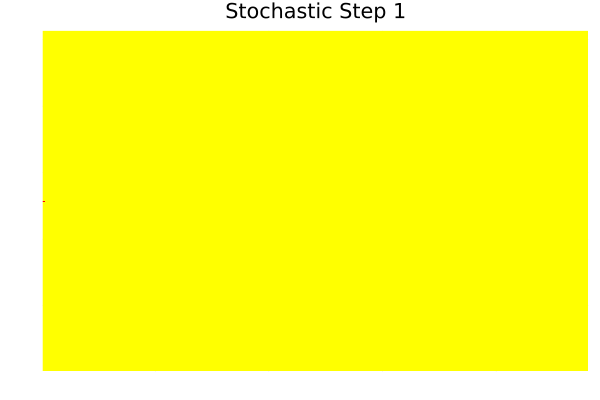

In [51]:
using Plots

@gif for t in 1:number_of_steps
    heatmap(
        stochastic_frames[t]', # the t-th frame
        c = cgrad([:yellow, :green, :red]),  # Color gradient from yellow to red
        legend = false,
        axis = false,
        title = "Stochastic Step $t"
    )
end every 1 # Every 1 frames

In [48]:
do_you_see_stochastic_rule_30_simulation_figure = true; # set to true if you see the figure above

__What is different?__

* The stochastic Rule 30 produces markedly different patterns compared to the deterministic simulation, even though both use identical underlying rules. The introduction of probabilistic state transitions and cooldown periods fundamentally alters the system's evolution, creating patterns that appear more fragmented and sparse than their deterministic counterpart.

* Instead of the smooth, continuous triangular expansion seen in the deterministic case, the stochastic simulation generates interrupted patterns with gaps and isolated clusters of activity. The probabilistic nature means that not every cell updates at each time step, creating a stuttering effect where pattern propagation becomes irregular and unpredictable. This leads to regions where the characteristic Rule 30 structures are broken or delayed, resulting in a more heterogeneous overall appearance.

* The cooldown mechanism introduces temporal dependencies that don't exist in the deterministic version, where recently updated cells must wait before participating in future transitions. This creates additional complexity and can lead to the formation of transient stable regions where activity becomes temporarily suppressed. 

The overall pattern retains some recognizable Rule 30 characteristics but with significantly more variability and less predictable boundaries, demonstrating how stochastic elements can dramatically alter emergent behavior while preserving the underlying mathematical structure.
___

## Tests

In the code block below, we check some values in your notebook and give you feedback on which items are correct or different. Unhide the code block below (if you are curious) to see how we implemented the tests and what we are testing.

In [53]:
@testset verbose = true "Tests for PS1 Wolfram Simulation" begin

    @testset "Setup" begin

        @test _INCLUDE_STUDENT_JL_CALLED == true; # the student version of the include file was called
        @test rulemodel.number_of_colors == 2
        @test rulemodel.radius == 3
        @test isnothing(rulemodel.rule) == false; # rule is not nothing
        @test isempty(rulemodel.rule) == false; # rule is not empty
    end

    @testset "Deterministic simulation tests" begin
        @test isnothing(base_frames) == false; # base frames is not nothing
        @test isempty(base_frames) == false; # base frames is not empty
        @test size(base_frames[1]) == (number_of_steps, number_of_states)
        @test do_you_see_deterministic_rule_30_simulation_figure == true
    end

    @testset "Stochastic simulation tests" begin
        @test isnothing(stochastic_frames) == false; # stochastic frames is not nothing
        @test isempty(stochastic_frames) == false; # stochastic frames is not empty
        @test size(stochastic_frames[1]) == (number_of_steps, number_of_states)
        @test do_you_see_stochastic_rule_30_simulation_figure == true
    end
end;

Test Summary:                    | Pass  Total  Time
Tests for PS1 Wolfram Simulation |   13     13  0.0s
  Setup                          |    5      5  0.0s
  Deterministic simulation tests |    4      4  0.0s
  Stochastic simulation tests    |    4      4  0.0s
